In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

/bin/bash: ../xvfb: No such file or directory


In [6]:
!pip install gymnasium[toy_text,classic_control]


  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Running setup.py clean for box2d-py
Failed to build box2d-py
    Running setup.py install for box2d-py: started
    Running setup.py install for box2d-py: finished with status 'error'


  ERROR: Command errored out with exit status 1:
   command: 'G:\Program Files\conda\python.exe' -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\dobry\\AppData\\Local\\Temp\\pip-install-3e7vmp6b\\box2d-py_9d28f62bbaa345d9a04feebfc0229b56\\setup.py'"'"'; __file__='"'"'C:\\Users\\dobry\\AppData\\Local\\Temp\\pip-install-3e7vmp6b\\box2d-py_9d28f62bbaa345d9a04feebfc0229b56\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\dobry\AppData\Local\Temp\pip-wheel-ov7gg05d'
       cwd: C:\Users\dobry\AppData\Local\Temp\pip-install-3e7vmp6b\box2d-py_9d28f62bbaa345d9a04feebfc0229b56\
  Complete output (16 lines):
  Using setuptools (version 61.2.0).
  running bdist_wheel
  running build
  running build_py
  creating build
  

state vector dim = 2
n_actions = 3
n_states=Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


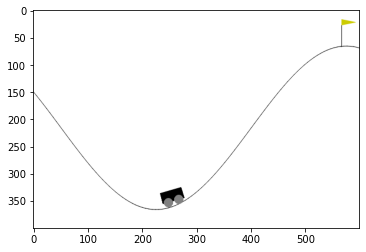

In [9]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("MountainCar-v0", render_mode="rgb_array").env

env.reset()

n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("state vector dim =", state_dim)
print("n_actions =", n_actions)
n_states = env.observation_space

print(f"n_states={n_states}")
env.close()

In [17]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(40, 20),
    activation="tanh",
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))


MLPClassifier(activation='tanh', hidden_layer_sizes=(40, 20))

In [11]:
def generate_session(env,agent,t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s, _ = env.reset()

    for t in range(t_max):

        # use agent to predict a vector of action probabilities for state :s:
        probs = agent.predict_proba([s])[0]

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"

        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(list(range(n_actions)),p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, terminated, truncated, _ = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break
    return states, actions, total_reward


In [12]:
dummy_states, dummy_actions, dummy_reward = generate_session(env,agent,t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)


states: [[-0.46462777  0.        ]
 [-0.46606776 -0.00143998]
 [-0.46893707 -0.00286932]
 [-0.47221452 -0.00327745]
 [-0.47687584 -0.00466131]]
actions: [0, 0, 1, 0, 0]
reward: -5.0


In [13]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)
    elite_states = []
    elite_actions = []

    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])

    return elite_states, elite_actions

In [14]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

mean reward = -155.120, threshold=-139.000


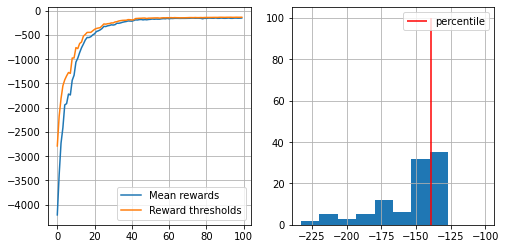

In [18]:
n_sessions = 100
percentile = 70
log = []

#print(f"{states_batch}\n{actions_batch}\n{rewards_batch}")
for i in range(100):
    # generate new sessions
    sessions = [ generate_session(env,agent,t_max=10000)for i in range(n_sessions) ]

    # states_batch=[el[0] for el in sessions],
    # actions_batch=[el[1] for el in sessions],
    # rewards_batch =[el[2] for el in sessions]
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,percentile)

    #print(f"{elite_states}\n {elite_actions}")
    agent.partial_fit(elite_states, elite_actions)

    show_progress(
        rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), -100]
    )

    if np.mean(rewards_batch) > -150:
        print("You Win! You may stop training now via KeyboardInterrupt.")


In [ ]:
# Record sessions

from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("MountainCar-v0", render_mode="rgb_array"),
    video_folder="./videos",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]


In [ ]:
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)
